In [351]:
import tensorflow as tf
tf.compat.v1.enable_eager_execution()
import numpy as np
import matplotlib.pyplot as plt
real_type = tf.float32
tf.executing_eagerly()

True

In [352]:
# From Savine's notebook

from scipy.stats import norm

def bsPrice(spot, strike, vol, T):
    d1 = (np.log(spot/strike) + 0.5 * vol * vol * T) / vol / np.sqrt(T)
    d2 = d1 - vol * np.sqrt(T)
    return spot * norm.cdf(d1) - strike * norm.cdf(d2)

def bsDelta(spot, strike, vol, T):
    d1 = (np.log(spot/strike) + 0.5 * vol * vol * T) / vol / np.sqrt(T)
    return norm.cdf(d1)

def bsVega(spot, strike, vol, T):
    d1 = (np.log(spot/strike) + 0.5 * vol * vol * T) / vol / np.sqrt(T)
    return spot * np.sqrt(T) * norm.pdf(d1)
    
class BlackScholes:
    
    def __init__(self, 
                 vol=0.2,
                 T1=1, 
                 T2=2, 
                 K=1.10,
                 volMult=1.5):
        
        self.spot = 1
        self.vol = vol
        self.T1 = T1
        self.T2 = T2
        self.K = K
        self.volMult = volMult
                        
    def trainingSet(self, m):
            
        returns = np.random.normal(size=[m, 2])

        vol0 = self.vol * self.volMult
        sigs = np.random.uniform(0.05, 0.5, size=m)
        R1 = np.exp(-0.5*vol0*vol0*self.T1 + vol0*np.sqrt(self.T1)*returns[:,0])
        R2 = np.exp(-0.5*sigs*sigs*(self.T2-self.T1) \
                    + sigs*np.sqrt(self.T2-self.T1)*returns[:,1])
        S1 = self.spot * R1
        #S1 = self.spot
        S2 = S1 * R2 

        pay = np.maximum(0, S2 - self.K)
        
        X = S1 #np.repeat(S1,m)
        X2 = sigs
        Y = pay

        Z =  np.where(S2 > self.K, R2, 0.0).reshape((-1,1)) 
        Z2 = np.where(S2 > self.K, S2*(-sigs*(self.T2-self.T1)+np.sqrt(self.T2-self.T1)*returns[:,1]), 0.0).reshape(-1,1)
        
        return np.c_[X.reshape([-1,1]), X2.reshape([-1,1])], Y.reshape([-1,1]), np.c_[Z.reshape([-1,1]),Z2.reshape([-1,1])]#np.c_[X.reshape([-1,1]),X2.reshape([-1,1])], Y.reshape([-1,1]), np.c_[Z.reshape([-1,1]),Z2.reshape([-1,1])]
    
    def testSet(self, lower=0.35, upper=1.65, num=100):
        
        spots = np.linspace(lower, upper, num).reshape((-1, 1))
        prices = bsPrice(spots, self.K, self.vol, self.T2 - self.T1).reshape((-1, 1))
        deltas = bsDelta(spots, self.K, self.vol, self.T2 - self.T1).reshape((-1, 1))
        return spots, prices, deltas   

In [319]:
class ForwardLayer(tf.keras.layers.Layer):
    def __init__(self, units, **kwargs):
        super().__init__(**kwargs)
        self.units = units
        
    def build(self, input_shape):
        self.w = self.add_weight(
            name = 'weights',
            shape=(input_shape[-1], self.units),
            initializer="glorot_normal",
            trainable=True
        )
        self.b = self.add_weight(
            name = 'bias',
            shape=(self.units,), 
            initializer="zeros", 
            trainable=True
        )
        super().build(input_shape)

    def call(self, inputs, first=False):
        if not first:
            return tf.keras.activations.softplus(inputs) @ self.w + self.b
        if first:
            return inputs @ self.w + self.b

class BackpropLayer(tf.keras.layers.Layer):
    def __init__(self, twin: ForwardLayer, units=20, **kwargs):
        super().__init__(**kwargs)
        self.twin = twin
        self.units = self.twin.units
        self.units = units

    def build(self, input_shape):
        self.w = self.twin.w
        super().build(input_shape)

    def call(self, inputs, output=False, first=False):
        if first:
            return tf.transpose(self.w) * tf.keras.activations.sigmoid(inputs)
        if not output and not first:
            z, zbar = inputs
            return zbar @ tf.transpose(self.w) * tf.keras.activations.sigmoid(z)
        if output and not first:
            return inputs @ tf.transpose(self.w)

class DiffLayer(tf.keras.layers.Layer):
    def __init__(self, units, **kwargs):
        super().__init__(**kwargs)
        self.units = units
        
    def build(self, input_shape):
        self.w = self.add_weight(
            name = 'weights',
            shape=(input_shape[-1], self.units),
            initializer="glorot_normal",
            trainable=True
        )
        self.b = self.add_weight(
            name = 'bias',
            shape=(self.units,), 
            initializer="zeros", 
            trainable=True
        )
        super().build(input_shape)

    def call(self, inputs, diff = False, first = False, output = False):
        if not diff:
            if not first:
                return tf.keras.activations.softplus(inputs) @ self.w + self.b
            if first:
                return inputs @ self.w + self.b
        if diff:
            if first:
                return tf.transpose(self.w) * tf.keras.activations.sigmoid(inputs)
            if not output and not first:
                z, zbar = inputs
                return zbar @ tf.transpose(self.w) * tf.keras.activations.sigmoid(z)
            if output and not first:
                return inputs @ tf.transpose(self.w)

In [320]:
epsilon = 1.0e-08
def normalize_data(x_raw, y_raw, dydx_raw):
    
    x_mean = x_raw.mean(axis=0)
    x_std = x_raw.std(axis=0) + epsilon
    x = (x_raw- x_mean) / x_std
    y_mean = y_raw.mean(axis=0)
    y_std = y_raw.std(axis=0) + epsilon
    y = (y_raw-y_mean) / y_std
    
    dydx = dydx_raw / y_std * x_std 
    lambda_j = 1.0 / np.sqrt((dydx ** 2).mean(axis=0)).reshape(1, -1)
   
    return x_mean, x_std, x, y_mean, y_std, y, dydx, lambda_j

In [321]:
def create_derivsLoss(lambda_j):
    def derivsLoss(dydx_true, dydx_pred):
        dydx_true = dydx_true  * lambda_j
        dydx_pred = dydx_pred * lambda_j
        error = dydx_true - dydx_pred
        return tf.reduce_mean(tf.square(error))
    return derivsLoss

In [322]:
class LRSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, n_epochs, size, batch_size):
    self.learning_rate_schedule = [   (0.0, 1.0e-8), \
                                      (0.2, 0.1),    \
                                      (0.6, 0.01),   \
                                      (0.9, 1.0e-6), \
                                      (1.0, 1.0e-8)  ]
    self.n_epochs = n_epochs
    self.lr_schedule_epochs, self.lr_schedule_rates = zip(*self.learning_rate_schedule)
    self.batch_size = batch_size
    self.size = size
    self.n_steps = self.batch_size * self.size
    self.epoch = 1
    self.counter = 0
    self.number = self.size/self.batch_size

  def __call__(self, step):
    self.counter += 1
    if self.counter % self.number == 0:
        self.epoch += 1
    lr = np.interp(self.epoch / self.n_epochs, self.lr_schedule_epochs, self.lr_schedule_rates)

    return lr 

In [323]:
combined = False

if not combined:

    # Defining the layers in the feedforward part of the network
    forward_1 = ForwardLayer(units=20, name='forward_1')
    forward_2 = ForwardLayer(units=20, name='forward_2')
    forward_3 = ForwardLayer(units=20, name='forward_3')
    forward_4 = ForwardLayer(units=20, name='forward_4')

    # Defining the output layer responsible for predicting y
    output = ForwardLayer(units=1, name='output')

    # Defining the layers in the backpropagation part of the network
    # The argument "twin" makes sure the weights are shared correctly
    backprop_1 = BackpropLayer(twin=output, name='backprop_1')
    backprop_2 = BackpropLayer(twin=forward_4, name = 'backprop_2')
    backprop_3 = BackpropLayer(twin=forward_3, name='backprop_3')
    backprop_4 = BackpropLayer(twin=forward_2, name='backprop_4')

    # Defining the output layer responsible for predicting Delta
    derivs = BackpropLayer(twin=forward_1, name='derivs')

    # This defines the computations in carried out by the network
    z0 = tf.keras.layers.Input(shape=(2,), name='input')

    z1 = forward_1(z0, first=True)
    z2 = forward_2(z1)
    z3 = forward_3(z2)
    z4 = forward_4(z3)

    y = output(z4)

    zbar4 = backprop_1(inputs=z4, first=True)
    zbar3 = backprop_2(inputs=[z3,zbar4])
    zbar2 = backprop_3(inputs=[z2,zbar3])
    zbar1 = backprop_4(inputs=[z1,zbar2])

    derivs = derivs(inputs=zbar1, output=True)

    # Using standard keras techniques to define the model, once the computational graph is in place
    model = tf.keras.Model(inputs=z0, outputs=[y,derivs])   
     
if combined:

    layer_1 = DiffLayer(units=20, name='layer_1')
    layer_2 = DiffLayer(units=20, name='layer_2')
    layer_3 = DiffLayer(units=20, name='layer_3')
    layer_4 = DiffLayer(units=20, name='layer_4')

    output = DiffLayer(units=1, name='output')

    z0 = tf.keras.layers.Input(shape=(1,), name='input')

    z1 = layer_1(z0, first=True)
    z2 = layer_2(z1)
    z3 = layer_3(z2)
    z4 = layer_4(z3)

    y = output(z4)

    zbar4 = output(inputs=z4, diff=True, first=True)
    zbar3 = layer_4(inputs=[z3,zbar4], diff=True)
    zbar2 = layer_3(inputs=[z2,zbar3], diff=True)
    zbar1 = layer_2(inputs=[z1,zbar2], diff=True)

    derivs = layer_1(inputs=zbar1, diff=True, output=True)

    model = tf.keras.Model(inputs=z0, outputs=[y,derivs])

In [324]:
n_epochs = 100; size = 2 ** 17; batch_size = int(max(256, size // 16)); scheduler = True

bs = BlackScholes()
xTrain, yTrain, dydxTrain = bs.trainingSet(size)
#xTrain = xTrain[:,1].reshape(-1,1); dydxTrain = dydxTrain[:,1].reshape(-1,1)
xTest, yTest, dydxTest = bs.testSet(num=100)

x_mean, x_std, x, y_mean, y_std, y, dydx, lambda_j = normalize_data(xTrain, yTrain, dydxTrain)

if scheduler:
    optimizer = tf.keras.optimizers.Adam(learning_rate=LRSchedule(n_epochs, size, batch_size))
    eager = True
else:    
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.1)
    #optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.1)
    eager = False

model.compile(loss=['mse', create_derivsLoss(lambda_j)], optimizer=optimizer, run_eagerly=eager)

history = model.fit(
    x, [y, dydx], epochs=n_epochs, batch_size = batch_size, verbose = 1
)

Epoch 1/100
16/16 [==============================] - 1s 36ms/step - loss: 1.7439 - output_loss: 0.8553 - derivs_loss: 0.8885
Epoch 2/100
16/16 [==============================] - 1s 36ms/step - loss: 1.4738 - output_loss: 0.6855 - derivs_loss: 0.7883
Epoch 3/100
16/16 [==============================] - 1s 32ms/step - loss: 1.3935 - output_loss: 0.6493 - derivs_loss: 0.7442
Epoch 4/100
16/16 [==============================] - 1s 33ms/step - loss: 1.3724 - output_loss: 0.6423 - derivs_loss: 0.7302
Epoch 5/100
16/16 [==============================] - 1s 32ms/step - loss: 1.3660 - output_loss: 0.6435 - derivs_loss: 0.7225
Epoch 6/100
16/16 [==============================] - 1s 37ms/step - loss: 1.3660 - output_loss: 0.6479 - derivs_loss: 0.7182
Epoch 7/100
16/16 [==============================] - 1s 34ms/step - loss: 1.3559 - output_loss: 0.6399 - derivs_loss: 0.7160
Epoch 8/100
16/16 [==============================] - 1s 36ms/step - loss: 1.3521 - output_loss: 0.6371 - derivs_loss: 0.7150


In [335]:
sig = np.linspace(0.05,0.5,100)
spt = np.repeat(1,100) #np.linspace(0.35,1.65,100)
xTest = np.c_[spt,sig]

x_scaled = (xTest - x_mean) / x_std
y_scaled, dydx_scaled = model.predict(x_scaled)

yPred = y_mean + y_std * y_scaled
dydxPred = y_std / x_std * dydx_scaled


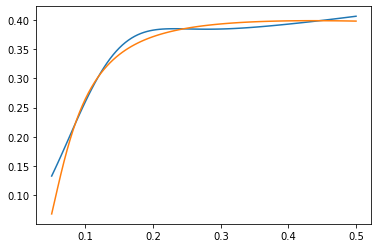

In [336]:
vega = []
for s in xTest[:,1]:
    vega.append(bsVega(1,1.1,s,1))

plt.plot(xTest[:,1], dydxPred[:,1])
plt.plot(xTest[:,1], vega)

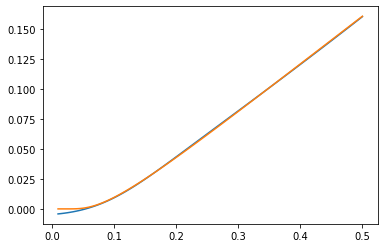

In [327]:
price = []
for s in xTest[:,1]:
    price.append(bsPrice(1,1.1,s,1))

plt.plot(xTest[:,1], yPred)
plt.plot(xTest[:,1], price)

In [347]:
sig = np.repeat(0.2,100) #np.linspace(0.01,0.5,100)
spt = np.linspace(0.35,1.65,100)
xTest = np.c_[spt,sig]

x_scaled = (xTest - x_mean) / x_std
y_scaled, dydx_scaled = model.predict(x_scaled)

yPred = y_mean + y_std * y_scaled
dydxPred = y_std / x_std * dydx_scaled

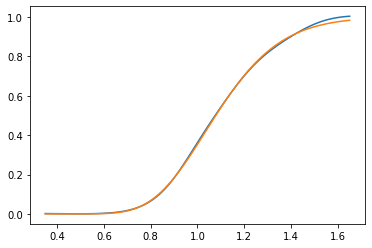

In [348]:
delta = []
for s in xTest[:,0]:
    delta.append(bsDelta(s,1.1,0.2,1))

plt.plot(xTest[:,0], dydxPred[:,0])
plt.plot(xTest[:,0], delta)

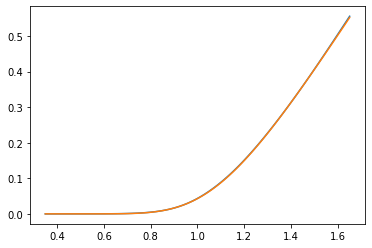

In [349]:
price = []
for s in xTest[:,0]:
    price.append(bsPrice(s,1.1,0.2,1))

plt.plot(xTest[:,0], yPred)
plt.plot(xTest[:,0], price)

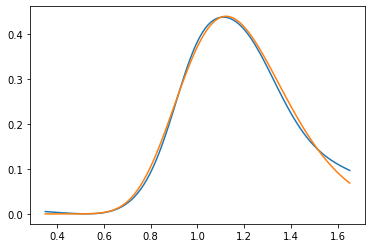

In [350]:
vgspt = []
for s in xTest[:,0]:
    vgspt.append(bsVega(s,1.1,0.2,1))

plt.plot(xTest[:,0], dydxPred[:,1])
plt.plot(xTest[:,0], vgspt)

In [345]:
bsVega(1,1.1,0.2,1)

0.3716384436594333